In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.249% 	8.95058% 	0.04888		0.04563		0.0		1.0	
(1024,256) 	95.4% 		0.49086% 	6.40525% 	0.82382		0.83287		0.0		0.98881	
(1024,1024) 	3.04% 		1.88876% 	2.25293% 	0.02452		0.00286		0.0		0.56883	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91948 0.90379 0.01569 	(688427, 0.938751472320377) 0.00671 0.93875 0.93204 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.89727 0.89420 0.00308 	(4240, 0.9623085983510011) 0.23896 0.96231 0.72334 	
(2436, 1.0) 0.98725 1.00000 0.01275 	(44828, 0.8401417658060423) 0.86901 0.84014 0.02886 	(694929, 0.9799764428739693) 0.00619 0.97998 0.97378 	
(55808, 1.0) 0.84739 1.00000 0.15261 	(232148, 0.8783613613364569) 0.88942 0.87836 0.01106 	(600540, 0.5747938751472321) 0.01367 0.57479 0.56112 	
(44159, 1.0) 0.99912 1.00000 0.00088 	(106790, 0.8420843224691953) 0.85826 0.84208 0.01618 	(226406, 0.8680800942285042) 0.07654 0.86808 0.79154 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.86602 0.82200 0.04402 	(122896, 0.99528857

(75907, 1.0) 1.00000 1.00000 0.00000 	(128738, 0.8907939275311966) 0.86659 0.89079 0.02420 	(478600, 0.9528857479387515) 0.04309 0.95289 0.90979 	
(49659, 1.0) 1.00000 1.00000 0.00000 	(45049, 0.8941921952489368) 0.86489 0.89419 0.02931 	(1053, 0.7997644287396938) 0.23269 0.79976 0.56708 	
(1921, 1.0) 0.48993 1.00000 0.51007 	(19331, 0.7751304321123971) 0.82142 0.77513 0.04629 	(69727, 0.9187279151943463) 0.15951 0.91873 0.75922 	
(83203, 1.0) 1.00000 1.00000 0.00000 	(137038, 0.9067975246968422) 0.87001 0.90680 0.03678 	(134243, 0.9599528857479388) 0.15719 0.95995 0.80276 	
(1412, 1.0) 0.42750 1.00000 0.57250 	(230832, 0.8657114302948561) 0.87980 0.86571 0.01409 	(168119, 0.4369846878680802) 0.05578 0.43698 0.38121 	
(69505, 1.0) 0.64626 1.00000 0.35374 	(131760, 0.8853994675194621) 0.87631 0.88540 0.00909 	(26889, 0.833922261484099) 0.11935 0.83392 0.71457 	
(59523, 1.0) 0.98664 1.00000 0.01336 	(129155, 0.7999979872765527) 0.85895 0.80000 0.05895 	(183631, 0.06478209658421678) 0.060

(7579, 1.0) 0.99998 1.00000 0.00002 	(25242, 0.7675573019314136) 0.85322 0.76756 0.08567 	(484601, 0.568904593639576) 0.01683 0.56890 0.55207 	
(46591, 1.0) 1.00000 1.00000 0.00000 	(75072, 0.8197714824987464) 0.87179 0.81977 0.05202 	(593006, 0.9988221436984688) 0.02826 0.99882 0.97057 	
(69510, 1.0) 0.99254 1.00000 0.00746 	(201969, 0.8519213326274235) 0.86524 0.85192 0.01332 	(214035, 0.795053003533569) 0.11848 0.79505 0.67658 	
(104576, 1.0) 1.00000 1.00000 0.00000 	(144387, 0.8451563176955528) 0.88536 0.84516 0.04021 	(18502, 0.9116607773851589) 0.23712 0.91166 0.67454 	
(97664, 1.0) 0.99943 1.00000 0.00057 	(252561, 0.9032751260514961) 0.90218 0.90328 0.00110 	(196927, 1.0) 0.04895 1.00000 0.95105 	
(1922, 1.0) 0.55592 1.00000 0.44408 	(256716, 0.8929296810236506) 0.90150 0.89293 0.00858 	(11464, 0.7891637220259129) 0.27673 0.78916 0.51244 	
(34944, 1.0) 1.00000 1.00000 0.00000 	(140073, 0.8372678113225259) 0.89514 0.83727 0.05788 	(279620, 0.8928150765606597) 0.06484 0.89282 0.8

(105985, 1.0) 1.00000 1.00000 0.00000 	(121159, 0.8188181979856338) 0.87333 0.81882 0.05451 	(582333, 0.9293286219081272) 0.01123 0.92933 0.91810 	
(86016, 1.0) 1.00000 1.00000 0.00000 	(192332, 0.8975279933311768) 0.90696 0.89753 0.00944 	(293965, 0.9305064782096585) 0.32525 0.93051 0.60526 	
(39068, 1.0) 0.67052 1.00000 0.32948 	(65451, 0.8024310944854609) 0.82402 0.80243 0.02159 	(90164, 0.8939929328621907) 0.15951 0.89399 0.73448 	
(4369, 1.0) 0.89323 1.00000 0.10677 	(230983, 0.8535026070003096) 0.87222 0.85350 0.01872 	(25121, 0.9210836277974088) 0.03468 0.92108 0.88640 	
(2946, 1.0) 0.73098 1.00000 0.26902 	(221516, 0.8699155548650045) 0.89235 0.86992 0.02243 	(75947, 0.9458186101295644) 0.10395 0.94582 0.84187 	
(51195, 1.0) 0.99998 1.00000 0.00002 	(13534, 0.8028836105579988) 0.82683 0.80288 0.02394 	(160238, 0.9481743227326267) 0.08106 0.94817 0.86712 	
(21258, 1.0) 1.00000 1.00000 0.00000 	(175125, 0.8496514747283541) 0.88026 0.84965 0.03060 	(388273, 0.9340400471142521) 0.0

(32383, 1.0) 1.00000 1.00000 0.00000 	(128595, 0.8617506791549723) 0.87663 0.86175 0.01488 	(653318, 1.0) 0.03781 1.00000 0.96219 	
(94219, 1.0) 0.99086 1.00000 0.00914 	(198166, 0.8384159289614866) 0.87219 0.83842 0.03377 	(116842, 0.6101295641931685) 0.15951 0.61013 0.45062 	
(40963, 1.0) 0.89455 1.00000 0.10545 	(243037, 0.882758693581502) 0.88995 0.88276 0.00719 	(137370, 0.9034157832744406) 0.12938 0.90342 0.77404 	
(19835, 1.0) 1.00000 1.00000 0.00000 	(62023, 0.8601789274400264) 0.85665 0.86018 0.00353 	(18460, 0.9811542991755006) 0.24099 0.98115 0.74016 	
(129280, 1.0) 1.00000 1.00000 0.00000 	(50937, 0.8313938941669136) 0.85756 0.83139 0.02616 	(446901, 0.96113074204947) 0.02789 0.96113 0.93324 	
(48128, 1.0) 0.93946 1.00000 0.06054 	(185502, 0.841465297201884) 0.86358 0.84147 0.02212 	(3603, 0.7361601884570083) 0.07225 0.73616 0.66391 	
(48522, 1.0) 0.94894 1.00000 0.05106 	(217997, 0.8950593016451204) 0.90858 0.89506 0.01352 	(468655, 0.9964664310954064) 0.00487 0.99647 0.99

(42056, 1.0) 0.99011 1.00000 0.00989 	(114103, 0.9408533716660923) 0.97179 0.94085 0.03094 	(303203, 0.7844522968197879) 0.05238 0.78445 0.73207 	
(13563, 1.0) 0.99989 1.00000 0.00011 	(22905, 0.8969083594940086) 0.84474 0.89691 0.05217 	(187623, 0.8987043580683157) 0.07570 0.89870 0.82301 	
(27263, 1.0) 0.99989 1.00000 0.00011 	(251644, 0.9021247242284586) 0.90232 0.90212 0.00019 	(190647, 0.4499411071849235) 0.05248 0.44994 0.39746 	
(34303, 1.0) 1.00000 1.00000 0.00000 	(134591, 0.8349057472229575) 0.86574 0.83491 0.03083 	(683604, 0.9752650176678446) 0.01361 0.97527 0.96166 	
(126081, 1.0) 1.00000 1.00000 0.00000 	(105188, 0.8451051561222844) 0.86903 0.84511 0.02392 	(554190, 0.5618374558303887) 0.02590 0.56184 0.53594 	
(34814, 1.0) 0.99995 1.00000 0.00005 	(228228, 0.8794205803218854) 0.89433 0.87942 0.01491 	(93286, 0.7879858657243817) 0.15951 0.78799 0.62848 	
(38664, 1.0) 0.66289 1.00000 0.33711 	(130070, 0.8189353866075423) 0.85780 0.81894 0.03886 	(220523, 0.9493521790341579

(27259, 1.0) 1.00000 1.00000 0.00000 	(158063, 0.8673615807902595) 0.87724 0.86736 0.00987 	(231133, 0.9269729093050648) 0.00683 0.92697 0.92014 	
(7939, 1.0) 0.99148 1.00000 0.00852 	(234328, 0.874781393625558) 0.88079 0.87478 0.00601 	(88134, 0.9976442873969376) 0.15951 0.99764 0.83814 	
(82178, 1.0) 1.00000 1.00000 0.00000 	(260501, 0.8805443579417024) 0.86158 0.88054 0.01897 	(263282, 0.6289752650176679) 0.08971 0.62898 0.53927 	
(9855, 1.0) 0.99992 1.00000 0.00008 	(123787, 0.8442056790026061) 0.87918 0.84421 0.03497 	(522442, 0.9340400471142521) 0.05269 0.93404 0.88135 	
(38142, 1.0) 1.00000 1.00000 0.00000 	(242387, 0.8730593950976218) 0.88975 0.87306 0.01669 	(565325, 0.9458186101295644) 0.35740 0.94582 0.58842 	
(8957, 1.0) 1.00000 1.00000 0.00000 	(105274, 0.9515216253790182) 0.87978 0.95152 0.07174 	(107091, 0.7314487632508835) 0.02024 0.73145 0.71121 	
(81026, 1.0) 1.00000 1.00000 0.00000 	(44919, 0.9098960912587629) 0.87218 0.90990 0.03772 	(735517, 0.955241460541814) 0.00

(86912, 1.0) 1.00000 1.00000 0.00000 	(19006, 0.8401443433428379) 0.80940 0.84014 0.03074 	(44250, 0.4040047114252061) 0.15951 0.40400 0.24450 	
(2948, 1.0) 0.96413 1.00000 0.03587 	(126713, 0.866448295670077) 0.87329 0.86645 0.00684 	(280851, 0.8362779740871614) 0.04990 0.83628 0.78638 	
(14110, 1.0) 0.99798 1.00000 0.00202 	(137298, 0.8220183682522815) 0.86582 0.82202 0.04381 	(184006, 0.5253239104829212) 0.00592 0.52532 0.51940 	
(54655, 1.0) 0.99975 1.00000 0.00025 	(21246, 0.8840065845222049) 0.82278 0.88401 0.06122 	(135207, 0.9988221436984688) 0.15951 0.99882 0.83931 	
(79747, 1.0) 1.00000 1.00000 0.00000 	(138584, 0.8965568443175121) 0.87833 0.89656 0.01823 	(288224, 0.9988221436984688) 0.02737 0.99882 0.97145 	
(27135, 1.0) 1.00000 1.00000 0.00000 	(112877, 0.9206918058369541) 0.94184 0.92069 0.02115 	(38136, 0.9069493521790342) 0.09584 0.90695 0.81111 	
(42116, 1.0) 0.99999 1.00000 0.00001 	(224729, 0.8985757531364934) 0.89054 0.89858 0.00803 	(38974, 0.8127208480565372) 0.15

(76943, 1.0) 0.99981 1.00000 0.00019 	(260121, 0.8137379243947204) 0.84709 0.81374 0.03335 	(51316, 0.9988221436984688) 0.15951 0.99882 0.83931 	
(2192, 1.0) 0.71742 1.00000 0.28258 	(66481, 0.9058222626938063) 0.88169 0.90582 0.02413 	(709107, 0.9988221436984688) 0.00732 0.99882 0.99150 	
(56067, 1.0) 0.98673 1.00000 0.01327 	(202722, 0.8630601619630203) 0.86901 0.86306 0.00595 	(52608, 0.7561837455830389) 0.15965 0.75618 0.59654 	
(23822, 1.0) 0.99752 1.00000 0.00248 	(20450, 0.7697050160704237) 0.81663 0.76971 0.04693 	(310512, 0.92226148409894) 0.04765 0.92226 0.87462 	
(7949, 1.0) 0.99999 1.00000 0.00001 	(65413, 0.7896934396692693) 0.83099 0.78969 0.04129 	(345622, 0.9093050647820966) 0.01739 0.90931 0.89191 	
(89345, 1.0) 0.94624 1.00000 0.05376 	(22062, 0.796444347763415) 0.76581 0.79644 0.03064 	(455841, 0.8904593639575972) 0.02387 0.89046 0.86659 	
(87043, 1.0) 1.00000 1.00000 0.00000 	(94688, 0.8929694493960458) 0.87722 0.89297 0.01575 	(258632, 0.9281507656065962) 0.01910 0

(22432, 1.0) 0.98826 1.00000 0.01174 	(129534, 0.8679993585768148) 0.87098 0.86800 0.00298 	(13573, 0.9375736160188458) 0.15810 0.93757 0.77948 	
(92805, 1.0) 1.00000 1.00000 0.00000 	(111461, 0.8373662177615897) 0.88618 0.83737 0.04881 	(78987, 0.9316843345111897) 0.15951 0.93168 0.77218 	
(18838, 1.0) 1.00000 1.00000 0.00000 	(200009, 0.8448961873934179) 0.85976 0.84490 0.01486 	(244802, 0.7114252061248528) 0.09438 0.71143 0.61704 	
(27284, 1.0) 0.98164 1.00000 0.01836 	(236541, 0.8968312679496214) 0.88335 0.89683 0.01348 	(755751, 0.9988221436984688) 0.04896 0.99882 0.94986 	
(97423, 1.0) 1.00000 1.00000 0.00000 	(106538, 0.894393269998844) 0.86647 0.89439 0.02792 	(230831, 0.9305064782096585) 0.04393 0.93051 0.88658 	
(48897, 1.0) 0.99999 1.00000 0.00001 	(113790, 0.9733947675958406) 0.97509 0.97339 0.00169 	(868912, 0.5665488810365136) 0.00403 0.56655 0.56252 	
(113793, 1.0) 1.00000 1.00000 0.00000 	(49410, 0.7956718475747022) 0.86092 0.79567 0.06525 	(51766, 0.9988221436984688) 0

(1695, 1.0) 0.14949 1.00000 0.85051 	(134308, 0.8816715621973813) 0.88705 0.88167 0.00538 	(256386, 0.7938751472320377) 0.05833 0.79388 0.73555 	
(2711, 1.0) 0.53749 1.00000 0.46251 	(180785, 0.9026056911826157) 0.87406 0.90261 0.02855 	(267424, 0.502944640753828) 0.05346 0.50294 0.44949 	
(59270, 1.0) 0.39285 1.00000 0.60715 	(127751, 0.8754034413411999) 0.86722 0.87540 0.00818 	(530726, 0.92226148409894) 0.02947 0.92226 0.89279 	
(42767, 1.0) 0.96825 1.00000 0.03175 	(80110, 0.8688109842150129) 0.90410 0.86881 0.03529 	(73866, 0.5100117785630154) 0.15951 0.51001 0.35050 	
(56981, 1.0) 0.94619 1.00000 0.05381 	(94081, 0.8582202106983956) 0.86317 0.85822 0.00495 	(196727, 0.5147232037691402) 0.09359 0.51472 0.42114 	
(31131, 1.0) 1.00000 1.00000 0.00000 	(101681, 0.8941588533045163) 0.86843 0.89416 0.02573 	(48, 0.9316843345111897) 0.28550 0.93168 0.64618 	
(113281, 1.0) 1.00000 1.00000 0.00000 	(31402, 0.8993755226643444) 0.85889 0.89938 0.04049 	(165176, 0.6383981154299176) 0.07303 0

(96386, 1.0) 0.51738 1.00000 0.48262 	(183675, 0.8595527157205531) 0.86348 0.85955 0.00393 	(124108, 0.9316843345111897) 0.18036 0.93168 0.75132 	
(49689, 1.0) 0.99996 1.00000 0.00004 	(226964, 0.8721223535284659) 0.88204 0.87212 0.00992 	(109889, 0.7997644287396938) 0.06924 0.79976 0.73052 	
(10888, 1.0) 0.98856 1.00000 0.01144 	(52941, 0.8946098235991085) 0.89353 0.89461 0.00108 	(141780, 0.9116607773851589) 0.03466 0.91166 0.87700 	
(43151, 1.0) 0.98284 1.00000 0.01716 	(146632, 0.9203756193125986) 0.89619 0.92038 0.02418 	(186869, 0.9905771495877504) 0.04350 0.99058 0.94707 	
(88195, 1.0) 1.00000 1.00000 0.00000 	(43129, 0.9837717148575006) 0.91186 0.98377 0.07191 	(75790, 0.9163722025912839) 0.24895 0.91637 0.66742 	
(49804, 1.0) 0.93704 1.00000 0.06296 	(59846, 0.8932541945094203) 0.86498 0.89325 0.02827 	(276594, 0.9988221436984688) 0.05065 0.99882 0.94817 	
(902, 1.0) 0.47409 1.00000 0.52591 	(62279, 0.8920165669881959) 0.85285 0.89202 0.03917 	(756784, 0.9116607773851589) 0.03

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


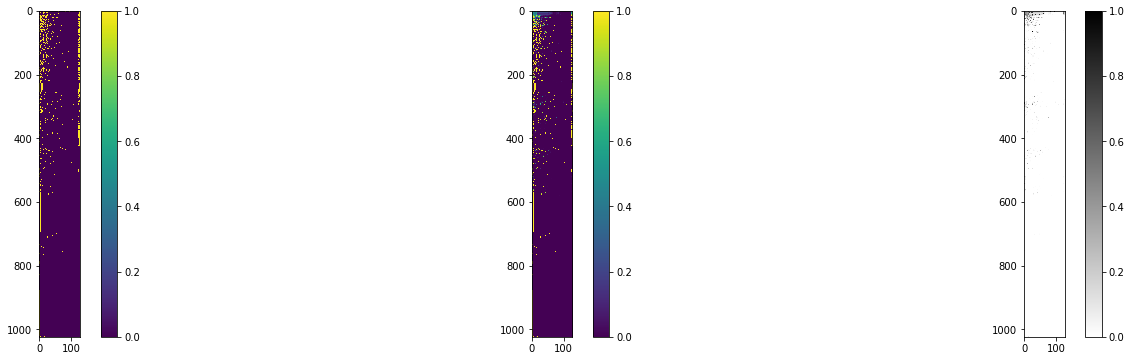

1.1244666e-24
0.98880833


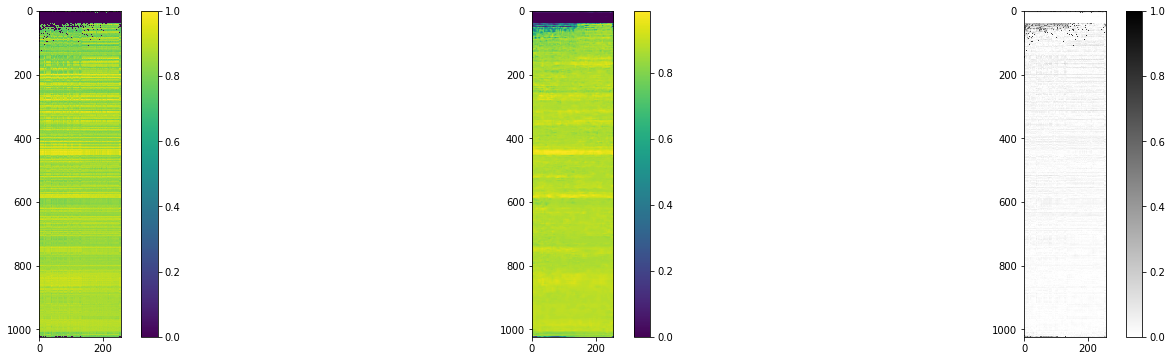

8.5232846e-14
0.56882685


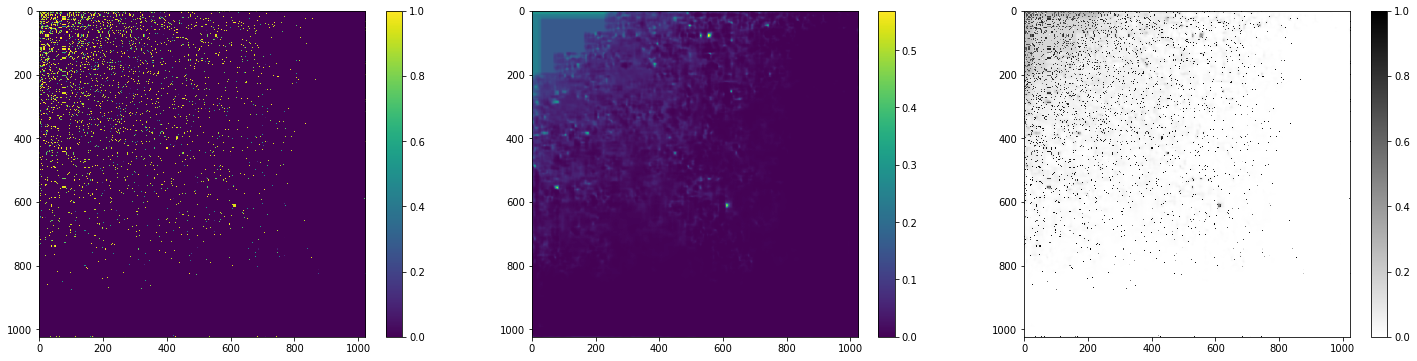

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_00/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


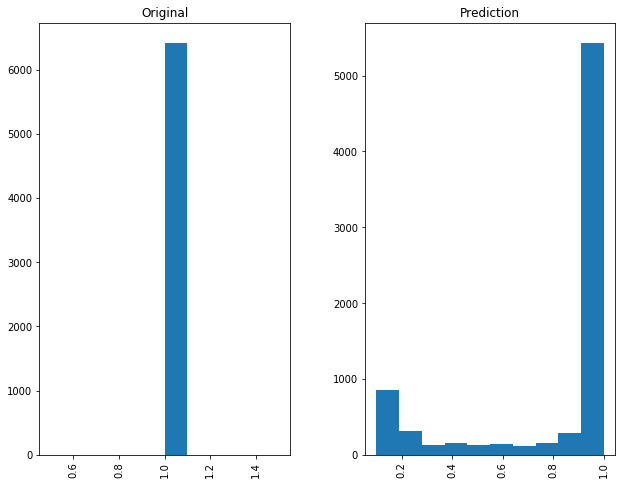

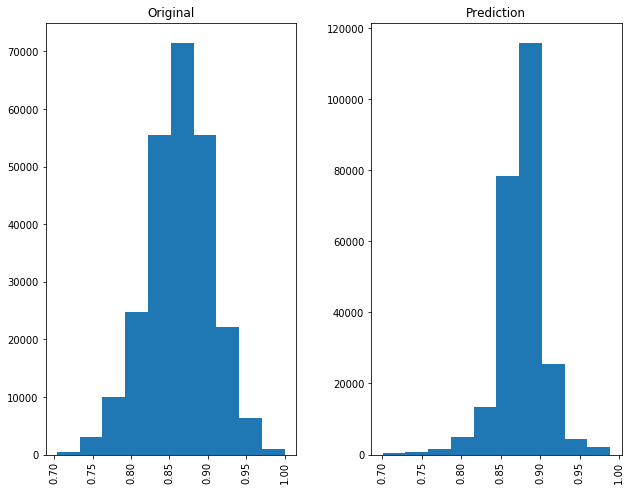

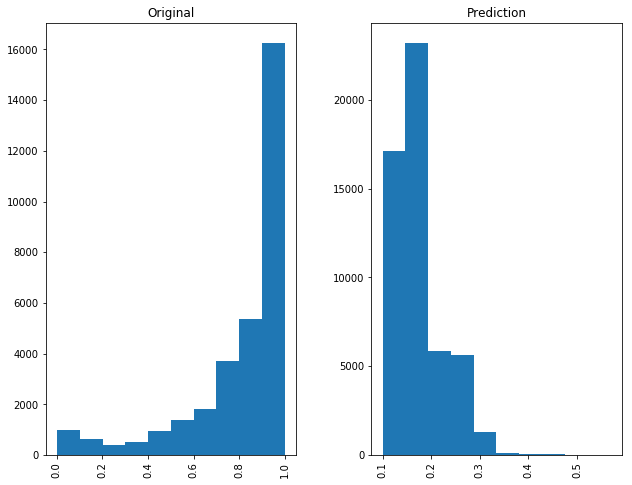

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


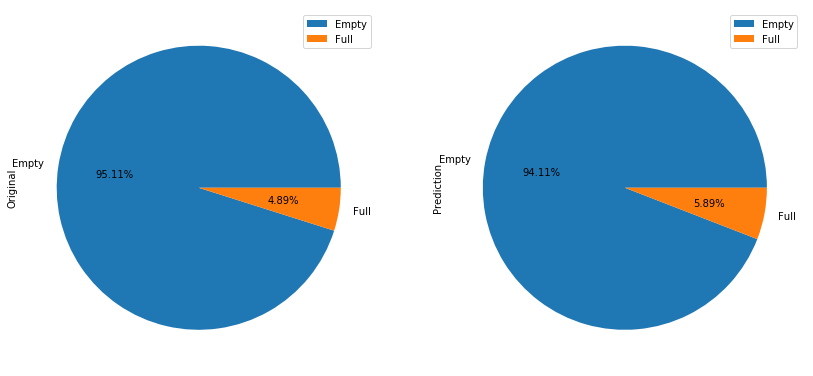

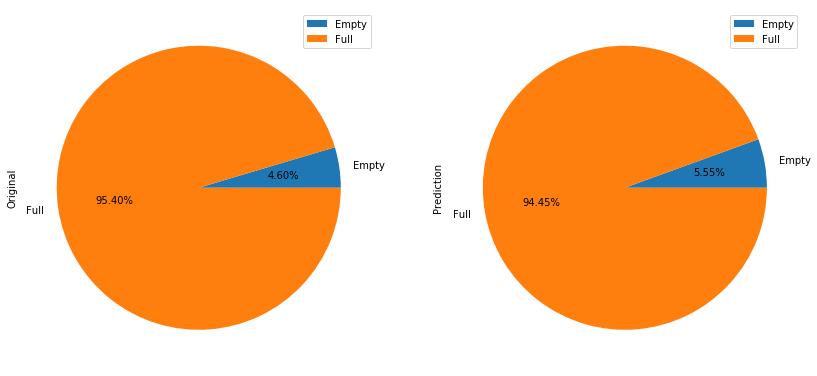

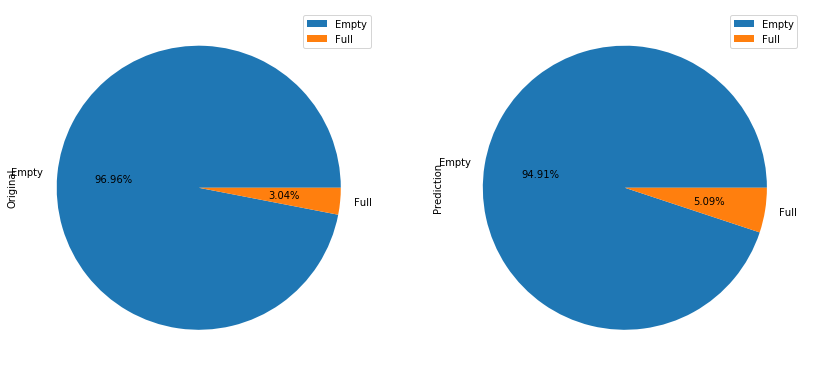

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

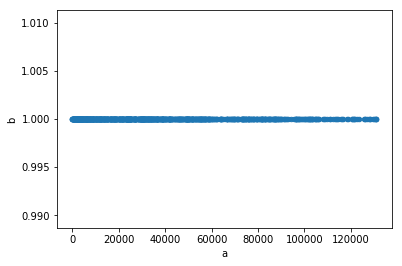

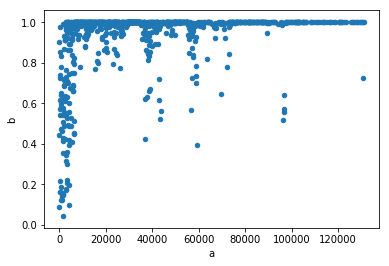

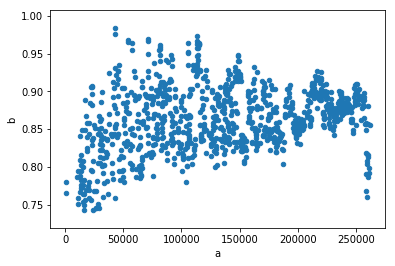

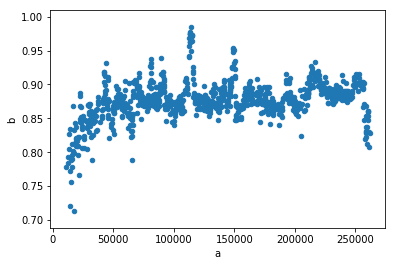

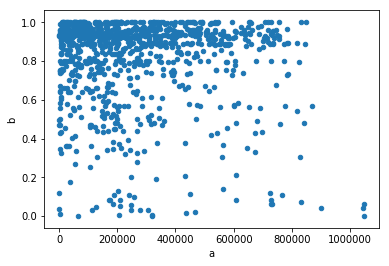

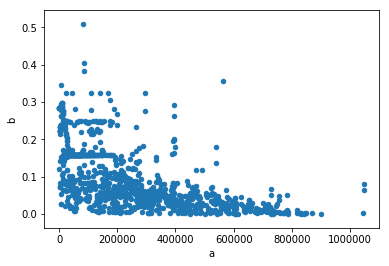

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

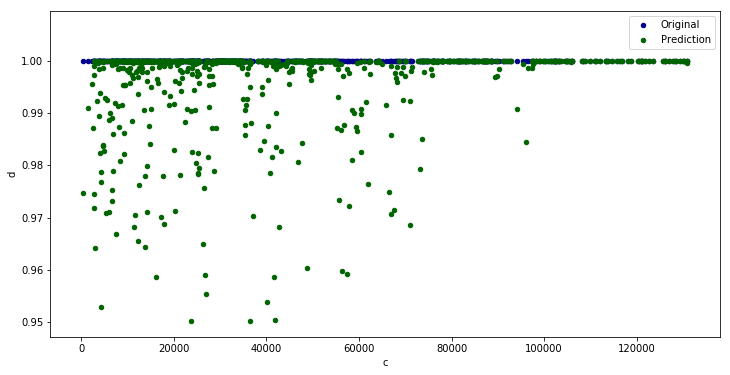

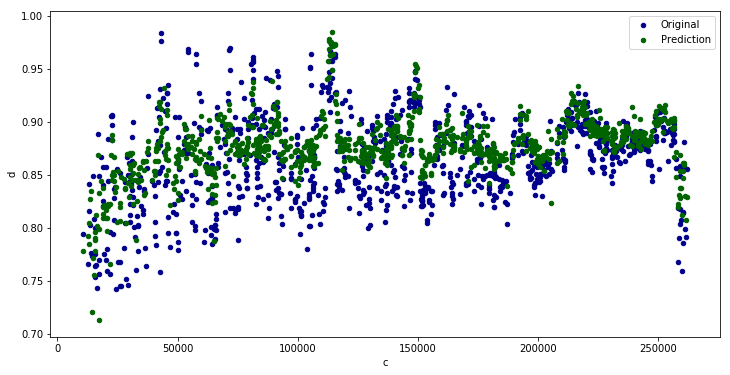

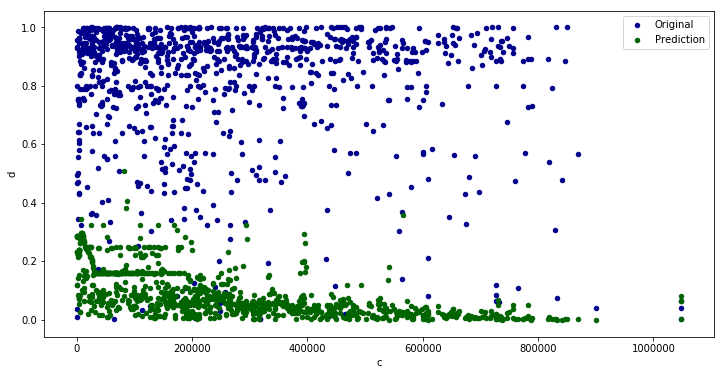

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

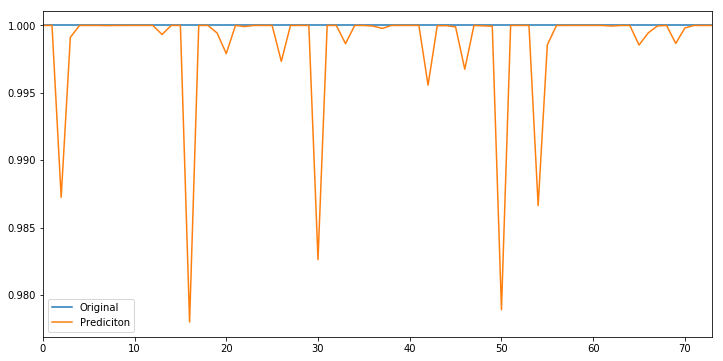

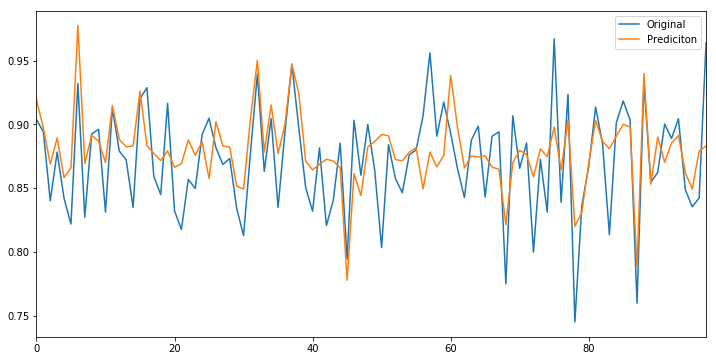

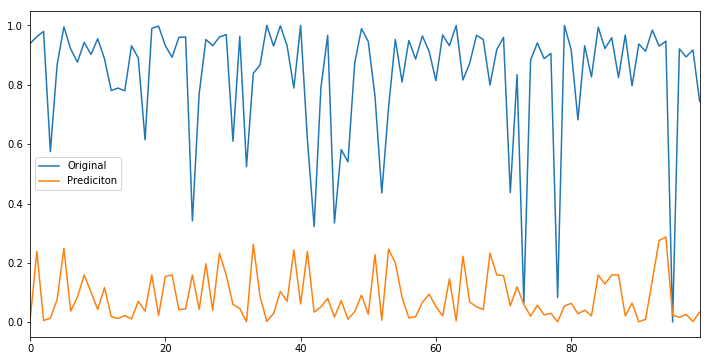

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))